In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

torch.__version__

'1.13.1'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## GAN MNIST Handwritten Digits using PyTorch

### Getting dataset

In [5]:
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

In [6]:
BATCH_SIZE = 32

In [7]:
custom_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # Due to tanh activation function
    torchvision.transforms.Normalize((0.5,), (0.5,))
])


train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=custom_transforms,
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE,
                          num_workers=0,
                          shuffle=True)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


In [8]:
print('Training Set:\n')
for images, labels in train_loader:  
    print('Image batch dimensions:', images.size())
    print('Image label dimensions:', labels.size())
    #print(labels[:10])
    break

Training Set:

Image batch dimensions: torch.Size([32, 1, 28, 28])
Image label dimensions: torch.Size([32])


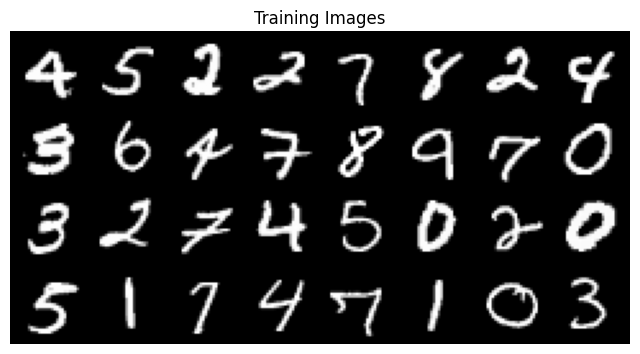

In [11]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")

plt.imshow(np.transpose(torchvision.utils.make_grid(
    #Plotting 64 images 
    images[:64], 
    padding=2, 
    normalize=True),
    (1, 2, 0))
    )
plt.show()

### Defining GAN model based on paper

In [12]:
class GAN(torch.nn.Module):

    def __init__(self, latent_dim=100, 
                 image_height=28, image_width=28, color_channels=1):
        super().__init__()
        
        self.image_height = image_height
        self.image_width = image_width
        self.color_channels = color_channels
        
        self.generator = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, image_height*image_width*color_channels),
            nn.Tanh()
        )
        
        #Binary cross-entropy
        self.discriminator = nn.Sequential(
            nn.Flatten(),
            nn.Linear(image_height*image_width*color_channels, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1), # outputs logits
            #nn.Sigmoid()
        )
    
    def generator_forward(self, z):# z has dimension NCHW
        z = torch.flatten(z, start_dim=1) 
        img = self.generator(z)

        #Reshaping it to Batch_size, C, H, W
        img = img.view(z.size(0),
                       self.color_channels,
                       self.image_height,
                       self.image_width)
        return img
    
    def discriminator_forward(self, img):
        logits = self.discriminator(img)
        return logits

In [13]:
model = GAN().to(device=device)

In [14]:
#OPtimizers only can update specific models

optim_gen = torch.optim.Adam(model.generator.parameters(), betas=(0.5, 0.999), lr=0.002)

optim_discr = torch.optim.Adam(model.discriminator.parameters(), betas=(0.5, 0.999), lr=0.002)

In [16]:
loss_fn = F.binary_cross_entropy_with_logits

In [15]:
log_dict = {'train_generator_loss_per_batch': [],
            'train_discriminator_loss_per_batch': [],
            'train_discriminator_real_acc_per_batch': [],
            'train_discriminator_fake_acc_per_batch': [],
            'images_from_noise_per_epoch': []
            }

In [18]:
fixed_noise = torch.randn(64, 100, 1, 1, device=device) #in the shape as batch, latent, height, width
fixed_noise.shape

torch.Size([64, 100, 1, 1])

In [19]:
import time

In [21]:
NUM_EPOCH = 100

In [24]:
start_time = time.time()

for epoch in range(NUM_EPOCH):
    model.train()
    for batch_idx, (features, _) in enumerate(train_loader):
        
        batch_size = features.size(0)

        #real images 
        real_images = features.to(device)
        real_labels = torch.ones(batch_size, device=device)

        # Fake images 
        noise = torch.randn(batch_size, 100, 1, 1, device=device)
        fake_images = model.generator_forward(noise)
        fake_labels = torch.zeros(batch_size, device=device)
        flipped_fake_labels = real_labels


        ########Training Discriminator#############
        optim_discr.zero_grad()

        # get discriminator loss on real images
        discr_pred_real = model.discriminator_forward(real_images).squeeze()
        real_loss = loss_fn(discr_pred_real, real_labels)

        discr_pred_fake = model.discriminator_forward(fake_images.detach()).squeeze()
        fake_loss = loss_fn(discr_pred_fake, fake_labels)

        #Combined loss Minmax
        discr_loss = 0.5*(real_loss + fake_loss)
        discr_loss.backward()
        optim_discr.step()

        ########Training Generator #########
        optim_gen.zero_grad()
        
        discr_pred_fake = model.discriminator_forward(fake_images).squeeze()
        #Labels all 1
        gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
        
        gener_loss.backward()
        optim_gen.step()


        ####### Logging
        log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
        log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())
        
        predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
        predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
        acc_real = (predicted_labels_real == real_labels).float().mean()*100.
        acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
        log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
        log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())         
        
        if not batch_idx % 50:
            print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f' 
                    % (epoch+1, NUM_EPOCH, batch_idx, 
                        len(train_loader), gener_loss.item(), discr_loss.item()))


with torch.inference_mode():
    fake_images = model.generator_forward(fixed_noise).detach().cpu()
    log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))
    
    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/100 | Batch 000/1875 | Gen/Dis Loss: 0.9408/0.3627
Epoch: 001/100 | Batch 050/1875 | Gen/Dis Loss: 0.7696/0.6214
Epoch: 001/100 | Batch 100/1875 | Gen/Dis Loss: 0.5728/0.6632
Epoch: 001/100 | Batch 150/1875 | Gen/Dis Loss: 0.7694/0.6309
Epoch: 001/100 | Batch 200/1875 | Gen/Dis Loss: 0.7730/0.5765
Epoch: 001/100 | Batch 250/1875 | Gen/Dis Loss: 0.7918/0.6128
Epoch: 001/100 | Batch 300/1875 | Gen/Dis Loss: 0.6134/0.6894
Epoch: 001/100 | Batch 350/1875 | Gen/Dis Loss: 0.8304/0.6398
Epoch: 001/100 | Batch 400/1875 | Gen/Dis Loss: 0.7198/0.6643
Epoch: 001/100 | Batch 450/1875 | Gen/Dis Loss: 0.7522/0.6345
Epoch: 001/100 | Batch 500/1875 | Gen/Dis Loss: 0.7009/0.6568
Epoch: 001/100 | Batch 550/1875 | Gen/Dis Loss: 0.7581/0.6362
Epoch: 001/100 | Batch 600/1875 | Gen/Dis Loss: 0.7177/0.6851
Epoch: 001/100 | Batch 650/1875 | Gen/Dis Loss: 0.7001/0.6962
Epoch: 001/100 | Batch 700/1875 | Gen/Dis Loss: 0.7593/0.6958
Epoch: 001/100 | Batch 750/1875 | Gen/Dis Loss: 0.7344/0.6802
Epoch: 0

In [27]:
def plot_multiple_training_losses(losses_list, num_epochs, 
                                  averaging_iterations=100, custom_labels_list=None):

    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')
    
    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]
    
    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    
    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')
    
    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

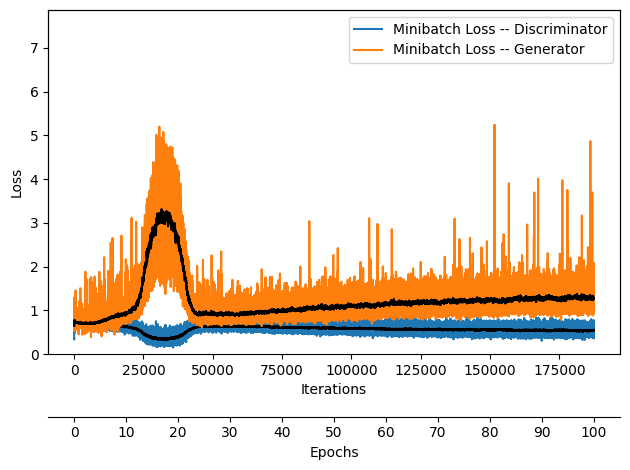

In [29]:
plot_multiple_training_losses(
    losses_list=(log_dict['train_discriminator_loss_per_batch'],
                 log_dict['train_generator_loss_per_batch']),
    num_epochs=NUM_EPOCH, 
    custom_labels_list=(' -- Discriminator', ' -- Generator')
)

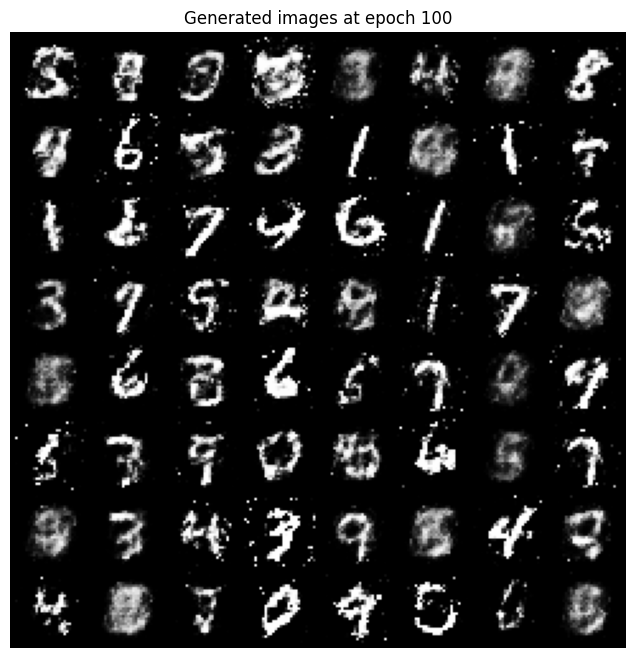

In [35]:
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images at epoch {100}')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][0], (1, 2, 0)))
plt.show()